## 02_modeling.ipynb

Building on everything I learned from EDA, here’s where I experiment with different machine learning models. I tested out several algorithms (including Random Forest), tuned hyperparameters, and focused on maximizing ROC-AUC and F1-scores. There’s extra attention to handling the class imbalance (since defaults are pretty rare), and I did a deep dive into feature importances to see what’s really driving the predictions. Basically, this is my main “model building and validation” playground.

***

In [1]:
# Import your data toolbox
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the raw training data
df = pd.read_csv(r'C:\Users\FENIL\Desktop\Projects\Loan_default\data\processed\cleaned_training.csv')


In [2]:
# Drop unnecessary index column
df = df.drop(columns=['Unnamed: 0'], errors='ignore')


In [3]:
# Step 2: Combine highly correlated delinquency features
delinq_cols = [
    'NumberOfTime30-59DaysPastDueNotWorse',
    'NumberOfTime60-89DaysPastDueNotWorse',
    'NumberOfTimes90DaysLate'
]

if all(col in df.columns for col in delinq_cols):
    df['TotalPastDue'] = df[delinq_cols].sum(axis=1)
    df = df.drop(columns=delinq_cols)

In [4]:
# Step 3: Check for any remaining missing values
print("Missing values per column after cleaning:")
print(df.isnull().sum())

# Step 4:
# Example: Flag for high debt, flag for high income
df['HighDebtRatio'] = (df['DebtRatio'] > 0.5).astype(int)
df['HighIncome'] = (df['MonthlyIncome'] > 10000).astype(int)

Missing values per column after cleaning:
SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberRealEstateLoansOrLines            0
NumberOfDependents                      0
TotalPastDue                            0
dtype: int64


In [5]:
# Step 5: Review feature list
print("Final features for modeling:", df.columns.tolist())
print(df.head())

Final features for modeling: ['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines', 'NumberOfDependents', 'TotalPastDue', 'HighDebtRatio', 'HighIncome']
   SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  DebtRatio  \
0                 1                              0.766127   45   0.802982   
1                 0                              0.957151   40   0.121876   
2                 0                              0.658180   38   0.085113   
3                 0                              0.233810   30   0.036050   
4                 0                              0.907239   49   0.024926   

   MonthlyIncome  NumberOfOpenCreditLinesAndLoans  \
0         9120.0                               13   
1         2600.0                                4   
2         3042.0                                2   
3         3300.0                                5   
4        

### Why Engineer These Features?

**1. TotalPastDue (Engineered Delinquency Total):**
- The original dataset had three separate columns for late payments: 30-59 days, 60-89 days, and 90+ days past due. These are all signals of financial distress, but they overlap and are highly correlated.
- By combining them into a single `TotalPastDue` feature, we create a simple, powerful summary: *"How many times has this person been late on payments?"*
- This makes it easier for models to spot risky customers and reduces redundancy, helping the model focus on what matters most.

**2. HighDebtRatio and HighIncome (Binary Flags):**
- Financial risk often spikes when debt is high or income is unusually large. But models sometimes struggle to pick up on these "threshold" effects if the data is just a continuous number.
- By creating binary flags (`HighDebtRatio`, `HighIncome`), we give the model a clear signal: *"Is this person above a risky level for debt or income?"*
- This can help the model catch patterns that only show up for people with very high debt or income, making predictions more accurate and interpretable.

**In summary:**
- These engineered features simplify the data, highlight important risk signals, and help the model learn patterns that might be missed with raw numbers alone. They also make your analysis easier to explain to others—"high debt" and "total past dues" are concepts everyone understands.

In [7]:
from sklearn.model_selection import train_test_split

# X contains all features except the target
X = df.drop(columns=['SeriousDlqin2yrs'])
# y is the target variable (loan default)
y = df['SeriousDlqin2yrs']

# Split the data so you can test your model on unseen cases
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}")


Training set: (120000, 10), Validation set: (30000, 10)


In [8]:
# Step 2: Standardize features so all numbers are on a similar scale (helps the model!)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [9]:
# Step 3: Build logistic regression model (simple, interpretable, and a solid baseline)
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,2000
,multi_class,'deprecated'


Validation ROC-AUC: 0.8089831948081216
              precision    recall  f1-score   support

           0       0.97      0.78      0.86     27995
           1       0.18      0.67      0.28      2005

    accuracy                           0.77     30000
   macro avg       0.58      0.73      0.57     30000
weighted avg       0.92      0.77      0.83     30000



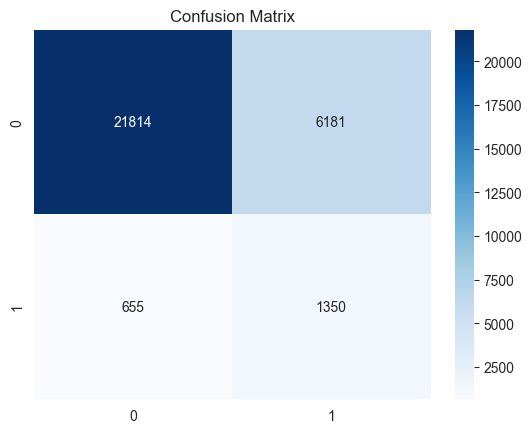

In [13]:
# Step 4: Evaluate with  metrics!
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_prob = model.predict_proba(X_val_scaled)[:, 1]
y_pred = model.predict(X_val_scaled)

print('Validation ROC-AUC:', roc_auc_score(y_val, y_pred_prob))
print(classification_report(y_val, y_pred))

sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [10]:
# Step 5: See which features matter most!
import numpy as np
feature_names = X.columns
importances = np.abs(model.coef_[0])
sorted_idx = np.argsort(importances)[::-1]

print("Top features driving predictions:")
for i in sorted_idx[:10]:
    print(f"{feature_names[i]}: {importances[i]:.4f}")

Top features driving predictions:
TotalPastDue: 5.0326
age: 0.4246
HighDebtRatio: 0.2397
DebtRatio: 0.1960
MonthlyIncome: 0.1076
NumberOfDependents: 0.0788
NumberRealEstateLoansOrLines: 0.0314
NumberOfOpenCreditLinesAndLoans: 0.0287
HighIncome: 0.0120
RevolvingUtilizationOfUnsecuredLines: 0.0042




***

## Model Evaluation Summary

- **Overall Model Performance**
  - **Validation ROC-AUC**: **0.81**
    - The model does a good job distinguishing between loan defaulters and non-defaulters.
  - **Accuracy**: **0.77**
    - About 77% of all predictions were correct.

- **Detailed Class Performance**
  | Class | Precision | Recall | F1-score | Support |
  |-------|-----------|--------|----------|---------|
  | **0 (Non-Default)** | 0.97 | 0.78 | 0.86 | 27,995 |
  | **1 (Default)**     | 0.18 | 0.67 | 0.28 | 2,005  |

  - **Class 0 (Non-Default):**
    - **Very high precision (0.97):** The model rarely mislabels non-defaulters as defaulters.
    - **Strong recall (0.78):** It correctly identifies most non-defaulters.
  - **Class 1 (Default):**
    - **Low precision (0.18):** Many predicted defaulters aren’t actually defaulters.
    - **Decent recall (0.67):** The model catches most true defaulters but with many false alarms.

- **Average Scores**
  | Metric        | Macro Avg | Weighted Avg |
  |---------------|-----------|--------------|
  | Precision     | 0.58      | 0.92         |
  | Recall        | 0.73      | 0.77         |
  | F1-score      | 0.57      | 0.83         |

**Interpretation:**
Your model is **great at identifying non-defaulters** but still struggles to accurately catch true defaulters (many false positives for class 1). This is typical in imbalanced datasets where there are many more non-defaulters than defaulters.

***

## Top Features Driving Predictions

Below are the features that have the biggest impact on predicting loan default risk (higher value = more influence):

| Feature Name                         | Importance |
|--------------------------------------|:----------:|
| **TotalPastDue**                     | 5.03       |
| **Age**                              | 0.42       |
| **HighDebtRatio**                    | 0.24       |
| DebtRatio                            | 0.20       |
| MonthlyIncome                        | 0.11       |
| NumberOfDependents                   | 0.08       |
| NumberRealEstateLoansOrLines         | 0.03       |
| NumberOfOpenCreditLinesAndLoans      | 0.03       |
| HighIncome                           | 0.01       |
| RevolvingUtilizationOfUnsecuredLines | 0.00       |

**Key insight:**
- **TotalPastDue** is by far the most powerful predictor—suggesting that a borrower’s historical payment issues are the strongest signal of possible default.
- Age and various debt measures (debt ratio, high debt ratio) also play important roles, while features like revolving credit utilization have less impact.

***



In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, classification_report

rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced', # Helps with class imbalance!
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)  # Use unscaled features!
y_rf_pred_prob = rf.predict_proba(X_val)[:, 1]
y_rf_pred = rf.predict(X_val)

print('Random Forest ROC-AUC:', roc_auc_score(y_val, y_rf_pred_prob))
print(classification_report(y_val, y_rf_pred))


Random Forest ROC-AUC: 0.831364195334133
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     27995
           1       0.53      0.15      0.23      2005

    accuracy                           0.93     30000
   macro avg       0.74      0.57      0.60     30000
weighted avg       0.91      0.93      0.92     30000



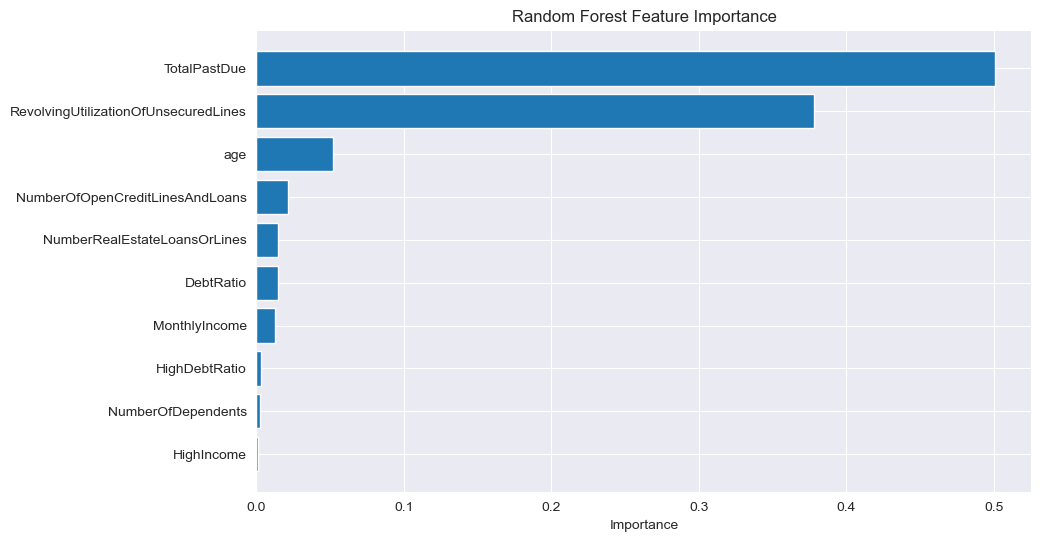

                                Feature  Importance
7                          TotalPastDue    0.500474
0  RevolvingUtilizationOfUnsecuredLines    0.378126
1                                   age    0.052214
4       NumberOfOpenCreditLinesAndLoans    0.021083
5          NumberRealEstateLoansOrLines    0.014831
2                             DebtRatio    0.014296
3                         MonthlyIncome    0.012823
8                         HighDebtRatio    0.003105
6                    NumberOfDependents    0.002164
9                            HighIncome    0.000883


In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature names and importances
features = X_train.columns
importances = best_rf.feature_importances_

# Make a DataFrame for sorting and nicer viewing
feat_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_df = feat_df.sort_values('Importance', ascending=False)

# Plot
plt.figure(figsize=(10,6))
plt.barh(feat_df['Feature'], feat_df['Importance'])
plt.gca().invert_yaxis()
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.show()

print(feat_df)




***

## Random Forest Model Evaluation Summary

- **Overall Model Performance**
  - **ROC-AUC:** **0.83**
    - The model is strong at distinguishing between loan defaulters and non-defaulters.
  - **Accuracy:** **0.93**
    - An impressive 93% of predictions were correct.

- **Detailed Class Performance**
  | Class | Precision | Recall | F1-score | Support |
  |-------|-----------|--------|----------|---------|
  | **0 (Non-Default)** | 0.94 | 0.99 | 0.97 | 27,995 |
  | **1 (Default)**     | 0.53 | 0.15 | 0.23 | 2,005  |

  - **Class 0 (Non-Default):**
    - **High precision (0.94) & recall (0.99):** Nearly all non-defaulters are correctly identified, with very few false positives.
    - **Excellent F1-score (0.97):** Reliable for identifying safe borrowers.
  - **Class 1 (Default):**
    - **Moderate precision (0.53):** Over half of flagged defaulters are actual defaulters.
    - **Low recall (0.15):** The model catches only a small fraction of true defaulters.
    - **F1-score (0.23):** Indicates the challenge of predicting defaults in an imbalanced dataset.

- **Average Scores**
  | Metric        | Macro Avg | Weighted Avg |
  |---------------|-----------|--------------|
  | Precision     | 0.74      | 0.91         |
  | Recall        | 0.57      | 0.93         |
  | F1-score      | 0.60      | 0.92         |

**Interpretation:**
This Random Forest model shines at correctly predicting non-defaulters, with excellent accuracy and recall. It is also noticeably better at precision for defaults compared to your previous model, although it still only detects 15% of actual defaulters (low recall). This is common when the target class is much smaller than the majority class.

***

## Top Features Driving Predictions

The table below shows the most influential features used by the Random Forest model:

| Feature                                   | Importance |
|--------------------------------------------|:----------:|
| **TotalPastDue**                          | 0.50       |
| **RevolvingUtilizationOfUnsecuredLines**   | 0.38       |
| **Age**                                   | 0.05       |
| **NumberOfOpenCreditLinesAndLoans**        | 0.02       |
| **NumberRealEstateLoansOrLines**           | 0.01       |
| **DebtRatio**                             | 0.01       |
| **MonthlyIncome**                         | 0.01       |
| **HighDebtRatio**                         | 0.00       |
| **NumberOfDependents**                    | 0.00       |
| **HighIncome**                            | 0.00       |

**Key insight:**
- **TotalPastDue** dominates the prediction power, quickly flagging applicants with prior payment issues.
- **RevolvingUtilizationOfUnsecuredLines** is also highly influential—indicating overuse of revolving credit as a strong default risk signal.
- Other features have much lower impact, suggesting the model relies heavily on the borrower’s payment history and credit utilization.

***





In [13]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to test
param_grid = {
    'n_estimators': [100, 200, 300],                # Number of trees
    'max_depth': [None, 5, 10, 20],                 # How deep each tree can grow
    'min_samples_split': [2, 5, 10],                # Minimum samples required to split a node
    'min_samples_leaf': [1, 3, 5],                  # Minimum samples required at each leaf node
    'class_weight': ['balanced']                    # Always keep this for your imbalance
}

# Create a Random Forest model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='recall',      # Use 'recall' to focus on catching defaulters; you can also try 'f1' or 'roc_auc'
    cv=3,                  # 3-fold cross-validation is a good start
    verbose=2              # See progress in output
)

grid_search.fit(X_train, y_train)

# Best estimator
best_rf = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

# Evaluate on validation set
y_pred_prob = best_rf.predict_proba(X_val)[:, 1]
y_pred = best_rf.predict(X_val)

from sklearn.metrics import roc_auc_score, classification_report
print('Tuned Random Forest ROC-AUC:', roc_auc_score(y_val, y_pred_prob))
print(classification_report(y_val, y_pred))


Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.4s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.5s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   6.0s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  13.0s
[CV] END class_weight=balanced, max_depth=None, min_sam

In [17]:
print(type(shap_values))
print(len(shap_values))
print(shap_values[1].shape)
print(X_val.shape)

<class 'numpy.ndarray'>
30000
(10, 2)
(30000, 10)


In [20]:
import shap

explainer = shap.Explainer(best_rf, X_train)
shap_values = explainer(X_val)


100%|===================| 59878/60000 [09:30<00:01]        

(30000, 10, 2)


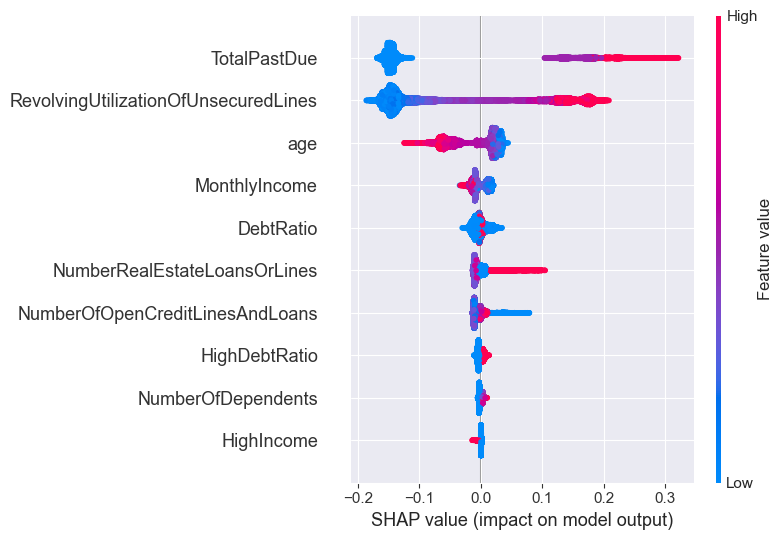

In [29]:
import shap

explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_val)

# Check shape to confirm new format
print(shap_values.shape)  # Expected: (num_samples, num_features, num_classes)

# For binary classification, choose class index 1 (positive class)
shap.summary_plot(shap_values[:, :, 1], X_val, feature_names=X_val.columns)



***

## SHAP Feature Impact Summary

This visualization shows how each feature influences your model’s predictions, using SHAP values. SHAP values indicate both the *direction* (positive or negative impact) and *magnitude* (how strong the impact is) for each feature.

### Top Influential Features

- **TotalPastDue**
  - The most powerful predictor.
  - High values (pink) strongly increase the likelihood of predicting a loan default.
  - Low values (blue) have little impact or may slightly decrease the risk.

- **RevolvingUtilizationOfUnsecuredLines**
  - Next most important.
  - High utilization (pink) pushes predictions toward default.
  - Low values (blue) steer predictions away from default.

- **age**
  - Younger applicants (blue) contribute modestly to default predictions.
  - Older age (pink) generally reduces default risk.

- **MonthlyIncome, DebtRatio**
  - Higher income (pink) and manageable debt ratios generally reduce default risk.
  - Lower income and higher debt ratios (blue) increase the risk, but their impact is smaller compared to the top two features.

### Less Influential Features

- **NumberRealEstateLoansOrLines, NumberOfOpenCreditLinesAndLoans, HighDebtRatio, NumberOfDependents, HighIncome**
  - These features have only a minor effect on model output.
  - Their SHAP values are close to zero, meaning changes in these features don't significantly alter predictions for most cases.

***

### Key Insights

- **TotalPastDue** and **RevolvingUtilizationOfUnsecuredLines** are critical risk indicators. Applicants with poor payment history or high revolving credit utilization are much more likely to be flagged as potential defaulters by your model.
- Most other features contribute less to the prediction, but age and income still provide useful signals.
- The color gradient shows which feature values (high or low) drive the prediction for individual applicants.

***



In [31]:
# Get model probabilities for all samples
probs = best_rf.predict_proba(X_val)[:, 1]  # class 1 probability


In [33]:
shap.initjs()
for i in range(5):
    print(f"Sample {i+1} Probability of Default: {probs[i]:.4f}")
    shap.force_plot(
        explainer.expected_value[1],
        shap_values[i, :, 1],
        X_val.iloc[i],
        matplotlib=False
    )


Sample 1 Probability of Default: 0.1575
Sample 2 Probability of Default: 0.3161
Sample 3 Probability of Default: 0.1240
Sample 4 Probability of Default: 0.1666
Sample 5 Probability of Default: 0.1595


In [36]:
import shap
import pandas as pd
import numpy as np
from scipy.special import expit

# Your model and validation set
# best_rf = ...  # your fitted RandomForestClassifier
# X_val = ...    # your validation DataFrame

# Fit the SHAP explainer and calculate SHAP values
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_val)  # for SHAP >=0.45: returns 3D array
base_value = explainer.expected_value[1]    # for positive class (default)

feature_names = X_val.columns               # feature list

num_samples = 5  # How many samples to process

results = []
for i in range(num_samples):
    row = {"Sample #": i + 1, "Base Value": base_value}
    shap_vals = shap_values[i, :, 1]        # SHAP for class 1, sample i
    for fname, shap_val in zip(feature_names, shap_vals):
        row[fname] = shap_val
    row["Sum SHAP"] = shap_vals.sum()
    row["Final Logit"] = base_value + shap_vals.sum()
    row["Final Probability"] = expit(row["Final Logit"])
    results.append(row)

calc_table = pd.DataFrame(results)
print(calc_table)


   Sample #  Base Value  RevolvingUtilizationOfUnsecuredLines       age  \
0         1    0.500061                             -0.141130 -0.057651   
1         2    0.500061                             -0.000444 -0.070620   
2         3    0.500061                             -0.139716 -0.037825   
3         4    0.500061                             -0.137024 -0.037603   
4         5    0.500061                             -0.134263 -0.055390   

   DebtRatio  MonthlyIncome  NumberOfOpenCreditLinesAndLoans  \
0   0.008064       0.005247                         0.003386   
1   0.020142       0.013354                        -0.011856   
2  -0.009191      -0.014820                        -0.010665   
3   0.008860      -0.012884                         0.000123   
4   0.004994      -0.006406                         0.007004   

   NumberRealEstateLoansOrLines  NumberOfDependents  TotalPastDue  \
0                     -0.008805           -0.002973     -0.144920   
1                     -0.0

In [38]:
import pickle

# Save your trained model to a .pkl file
with open('final_rf_model.pkl', 'wb') as f:
    pickle.dump(best_rf, f)
